In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image

In [ ]:
cifar_train = datasets.CIFAR10("data", train = True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("data", train = False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 81405458.59it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = 64, shuffle=False)

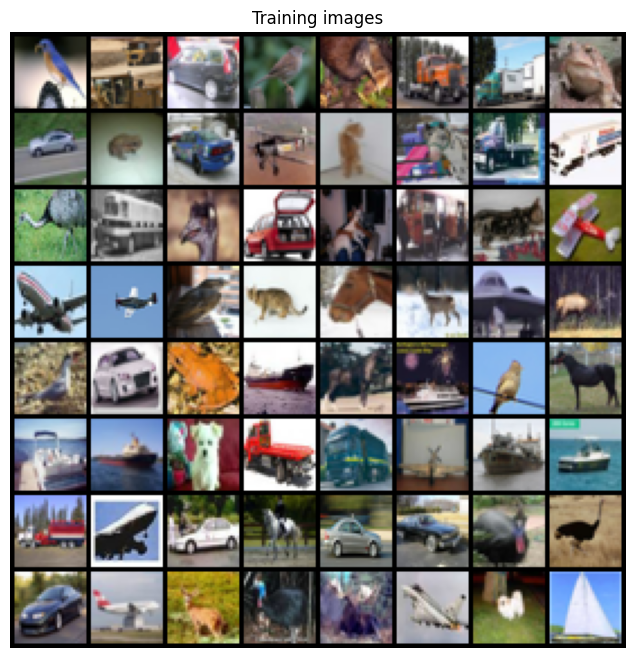

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images, labels in train_loader:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
               images[:64],
               padding=2,
               normalize=True),
               (1, 2, 0)))
    plt.show()
    break

#RESNET MODEL

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters(): # Freeze all layers
  param.requires_grad = False

In [ ]:
model.fc = torch.nn.Linear(512,10)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
list(model.fc.parameters())[0].requires_grad

True

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
  model.to(device)
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
  model.to(device)
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

model.to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train(data_loader = train_loader,
        model = model,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device,
        train_losses = train_losses,
        train_accuracy = train_accuracy
        )
  test(data_loader = test_loader,
       model = model,
       loss_fn = loss_fn,
       accuracy_fn = accuracy_fn,
       device = device,
       test_losses = test_losses,
       test_accuracy = test_accuracy
       )

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.57857 | Train accuracy: 45.05%


  1%|          | 1/100 [00:14<23:50, 14.45s/it]

Test loss: 1.58345 | Test accuracy: 45.63%

Epoch: 1
-------
Train loss: 1.58017 | Train accuracy: 45.25%


  2%|▏         | 2/100 [00:28<23:28, 14.37s/it]

Test loss: 1.65928 | Test accuracy: 43.90%

Epoch: 2
-------
Train loss: 1.58128 | Train accuracy: 45.03%


  3%|▎         | 3/100 [00:43<23:43, 14.67s/it]

Test loss: 1.60346 | Test accuracy: 44.99%

Epoch: 3
-------
Train loss: 1.57873 | Train accuracy: 45.20%


  4%|▍         | 4/100 [00:59<23:54, 14.94s/it]

Test loss: 1.59759 | Test accuracy: 45.15%

Epoch: 4
-------
Train loss: 1.58030 | Train accuracy: 45.24%


  5%|▌         | 5/100 [01:13<23:31, 14.86s/it]

Test loss: 1.58684 | Test accuracy: 45.59%

Epoch: 5
-------
Train loss: 1.58257 | Train accuracy: 44.73%


  6%|▌         | 6/100 [01:28<23:01, 14.70s/it]

Test loss: 1.58971 | Test accuracy: 45.67%

Epoch: 6
-------
Train loss: 1.58064 | Train accuracy: 45.10%


  7%|▋         | 7/100 [01:43<22:48, 14.71s/it]

Test loss: 1.61625 | Test accuracy: 44.83%

Epoch: 7
-------
Train loss: 1.58057 | Train accuracy: 45.45%


  8%|▊         | 8/100 [01:57<22:23, 14.61s/it]

Test loss: 1.58864 | Test accuracy: 45.46%

Epoch: 8
-------
Train loss: 1.58431 | Train accuracy: 45.05%


  9%|▉         | 9/100 [02:11<22:01, 14.53s/it]

Test loss: 1.58209 | Test accuracy: 45.99%

Epoch: 9
-------
Train loss: 1.58227 | Train accuracy: 44.80%


 10%|█         | 10/100 [02:26<21:45, 14.51s/it]

Test loss: 1.59830 | Test accuracy: 45.20%

Epoch: 10
-------
Train loss: 1.57969 | Train accuracy: 45.07%


 11%|█         | 11/100 [02:40<21:27, 14.46s/it]

Test loss: 1.61529 | Test accuracy: 44.75%

Epoch: 11
-------
Train loss: 1.58192 | Train accuracy: 44.91%


 12%|█▏        | 12/100 [02:55<21:24, 14.59s/it]

Test loss: 1.59163 | Test accuracy: 45.15%

Epoch: 12
-------
Train loss: 1.57985 | Train accuracy: 44.92%


 13%|█▎        | 13/100 [03:09<21:02, 14.51s/it]

Test loss: 1.59997 | Test accuracy: 45.50%

Epoch: 13
-------
Train loss: 1.58390 | Train accuracy: 44.98%


 14%|█▍        | 14/100 [03:24<20:42, 14.44s/it]

Test loss: 1.61441 | Test accuracy: 44.56%

Epoch: 14
-------
Train loss: 1.58194 | Train accuracy: 44.81%


 15%|█▌        | 15/100 [03:38<20:22, 14.38s/it]

Test loss: 1.59714 | Test accuracy: 45.31%

Epoch: 15
-------
Train loss: 1.57958 | Train accuracy: 45.22%


 16%|█▌        | 16/100 [03:52<20:04, 14.34s/it]

Test loss: 1.60092 | Test accuracy: 45.73%

Epoch: 16
-------
Train loss: 1.57944 | Train accuracy: 45.22%


 17%|█▋        | 17/100 [04:07<19:54, 14.40s/it]

Test loss: 1.58726 | Test accuracy: 45.46%

Epoch: 17
-------
Train loss: 1.57793 | Train accuracy: 45.02%


 18%|█▊        | 18/100 [04:21<19:45, 14.46s/it]

Test loss: 1.57719 | Test accuracy: 46.59%

Epoch: 18
-------
Train loss: 1.58157 | Train accuracy: 45.28%


 19%|█▉        | 19/100 [04:35<19:22, 14.35s/it]

Test loss: 1.61932 | Test accuracy: 43.95%

Epoch: 19
-------
Train loss: 1.58034 | Train accuracy: 44.72%


 20%|██        | 20/100 [04:49<19:02, 14.29s/it]

Test loss: 1.58843 | Test accuracy: 45.92%

Epoch: 20
-------
Train loss: 1.58461 | Train accuracy: 45.11%


 21%|██        | 21/100 [05:04<18:47, 14.27s/it]

Test loss: 1.57262 | Test accuracy: 46.61%

Epoch: 21
-------
Train loss: 1.57608 | Train accuracy: 45.19%


 22%|██▏       | 22/100 [05:18<18:32, 14.26s/it]

Test loss: 1.57548 | Test accuracy: 46.54%

Epoch: 22
-------
Train loss: 1.57677 | Train accuracy: 45.26%


 23%|██▎       | 23/100 [05:33<18:30, 14.43s/it]

Test loss: 1.59875 | Test accuracy: 45.67%

Epoch: 23
-------
Train loss: 1.58038 | Train accuracy: 44.93%


 24%|██▍       | 24/100 [05:47<18:10, 14.35s/it]

Test loss: 1.64501 | Test accuracy: 43.06%

Epoch: 24
-------
Train loss: 1.57994 | Train accuracy: 45.18%


 25%|██▌       | 25/100 [06:01<17:52, 14.30s/it]

Test loss: 1.59851 | Test accuracy: 45.58%

Epoch: 25
-------
Train loss: 1.58110 | Train accuracy: 44.96%


 26%|██▌       | 26/100 [06:15<17:35, 14.26s/it]

Test loss: 1.58054 | Test accuracy: 45.52%

Epoch: 26
-------
Train loss: 1.58125 | Train accuracy: 45.14%


 27%|██▋       | 27/100 [06:29<17:19, 14.24s/it]

Test loss: 1.65012 | Test accuracy: 43.11%

Epoch: 27
-------
Train loss: 1.57951 | Train accuracy: 44.99%


 28%|██▊       | 28/100 [06:45<17:27, 14.55s/it]

Test loss: 1.60519 | Test accuracy: 45.23%

Epoch: 28
-------
Train loss: 1.57521 | Train accuracy: 45.17%


 29%|██▉       | 29/100 [06:59<17:09, 14.50s/it]

Test loss: 1.60325 | Test accuracy: 45.45%

Epoch: 29
-------
Train loss: 1.58292 | Train accuracy: 44.93%


 30%|███       | 30/100 [07:14<16:57, 14.53s/it]

Test loss: 1.60101 | Test accuracy: 45.73%

Epoch: 30
-------
Train loss: 1.57868 | Train accuracy: 45.02%


 31%|███       | 31/100 [07:29<16:50, 14.65s/it]

Test loss: 1.57538 | Test accuracy: 46.40%

Epoch: 31
-------
Train loss: 1.57951 | Train accuracy: 45.21%


 32%|███▏      | 32/100 [07:44<16:43, 14.76s/it]

Test loss: 1.58173 | Test accuracy: 46.47%

Epoch: 32
-------
Train loss: 1.57809 | Train accuracy: 45.14%


 33%|███▎      | 33/100 [07:59<16:39, 14.91s/it]

Test loss: 1.61512 | Test accuracy: 45.14%

Epoch: 33
-------
Train loss: 1.58106 | Train accuracy: 45.14%


 34%|███▍      | 34/100 [08:14<16:23, 14.90s/it]

Test loss: 1.58986 | Test accuracy: 45.65%

Epoch: 34
-------
Train loss: 1.58075 | Train accuracy: 45.21%


 35%|███▌      | 35/100 [08:29<16:08, 14.89s/it]

Test loss: 1.57938 | Test accuracy: 45.83%

Epoch: 35
-------
Train loss: 1.58088 | Train accuracy: 45.41%


 36%|███▌      | 36/100 [08:44<15:58, 14.98s/it]

Test loss: 1.57655 | Test accuracy: 45.53%

Epoch: 36
-------
Train loss: 1.58337 | Train accuracy: 45.02%


 37%|███▋      | 37/100 [08:59<15:49, 15.07s/it]

Test loss: 1.58756 | Test accuracy: 45.33%

Epoch: 37
-------
Train loss: 1.58144 | Train accuracy: 45.10%


 38%|███▊      | 38/100 [09:13<15:15, 14.76s/it]

Test loss: 1.58390 | Test accuracy: 46.07%

Epoch: 38
-------
Train loss: 1.57994 | Train accuracy: 45.12%


 39%|███▉      | 39/100 [09:27<14:50, 14.59s/it]

Test loss: 1.59580 | Test accuracy: 45.24%

Epoch: 39
-------
Train loss: 1.58051 | Train accuracy: 45.13%


 40%|████      | 40/100 [09:42<14:35, 14.59s/it]

Test loss: 1.59450 | Test accuracy: 45.97%

Epoch: 40
-------
Train loss: 1.58151 | Train accuracy: 45.20%


 41%|████      | 41/100 [09:57<14:24, 14.65s/it]

Test loss: 1.59074 | Test accuracy: 45.92%

Epoch: 41
-------
Train loss: 1.58058 | Train accuracy: 44.95%


 42%|████▏     | 42/100 [10:12<14:16, 14.76s/it]

Test loss: 1.60213 | Test accuracy: 45.40%

Epoch: 42
-------
Train loss: 1.57964 | Train accuracy: 44.95%


 43%|████▎     | 43/100 [10:26<13:59, 14.72s/it]

Test loss: 1.59195 | Test accuracy: 45.48%

Epoch: 43
-------
Train loss: 1.57869 | Train accuracy: 45.36%


 44%|████▍     | 44/100 [10:41<13:42, 14.69s/it]

Test loss: 1.58032 | Test accuracy: 46.30%

Epoch: 44
-------
Train loss: 1.57694 | Train accuracy: 45.16%


 45%|████▌     | 45/100 [10:56<13:26, 14.67s/it]

Test loss: 1.58365 | Test accuracy: 46.42%

Epoch: 45
-------
Train loss: 1.57539 | Train accuracy: 45.21%


 46%|████▌     | 46/100 [11:11<13:16, 14.76s/it]

Test loss: 1.58658 | Test accuracy: 45.95%

Epoch: 46
-------
Train loss: 1.57870 | Train accuracy: 45.29%


 47%|████▋     | 47/100 [11:24<12:47, 14.49s/it]

Test loss: 1.58826 | Test accuracy: 45.71%

Epoch: 47
-------
Train loss: 1.57806 | Train accuracy: 45.34%


 48%|████▊     | 48/100 [11:39<12:31, 14.46s/it]

Test loss: 1.59286 | Test accuracy: 45.70%

Epoch: 48
-------
Train loss: 1.58048 | Train accuracy: 45.04%


 49%|████▉     | 49/100 [11:53<12:18, 14.48s/it]

Test loss: 1.59932 | Test accuracy: 45.48%

Epoch: 49
-------
Train loss: 1.58559 | Train accuracy: 45.03%


 50%|█████     | 50/100 [12:08<12:04, 14.50s/it]

Test loss: 1.58161 | Test accuracy: 46.34%

Epoch: 50
-------
Train loss: 1.57875 | Train accuracy: 45.23%


 51%|█████     | 51/100 [12:23<12:02, 14.74s/it]

Test loss: 1.58238 | Test accuracy: 46.02%

Epoch: 51
-------
Train loss: 1.57631 | Train accuracy: 45.01%


 52%|█████▏    | 52/100 [12:38<11:47, 14.74s/it]

Test loss: 1.62582 | Test accuracy: 44.63%

Epoch: 52
-------
Train loss: 1.58752 | Train accuracy: 45.14%


 53%|█████▎    | 53/100 [12:52<11:29, 14.66s/it]

Test loss: 1.59137 | Test accuracy: 45.70%

Epoch: 53
-------
Train loss: 1.58250 | Train accuracy: 45.00%


 54%|█████▍    | 54/100 [13:07<11:12, 14.62s/it]

Test loss: 1.58484 | Test accuracy: 45.62%

Epoch: 54
-------
Train loss: 1.57981 | Train accuracy: 45.12%


 55%|█████▌    | 55/100 [13:21<10:50, 14.45s/it]

Test loss: 1.59423 | Test accuracy: 45.88%

Epoch: 55
-------
Train loss: 1.57963 | Train accuracy: 45.04%


 56%|█████▌    | 56/100 [13:36<10:40, 14.57s/it]

Test loss: 1.57452 | Test accuracy: 46.08%

Epoch: 56
-------
Train loss: 1.58395 | Train accuracy: 44.95%


 57%|█████▋    | 57/100 [13:50<10:25, 14.56s/it]

Test loss: 1.62884 | Test accuracy: 44.09%

Epoch: 57
-------
Train loss: 1.57819 | Train accuracy: 45.05%


 58%|█████▊    | 58/100 [14:05<10:09, 14.50s/it]

Test loss: 1.58932 | Test accuracy: 45.72%

Epoch: 58
-------
Train loss: 1.57937 | Train accuracy: 45.35%


 59%|█████▉    | 59/100 [14:19<09:52, 14.46s/it]

Test loss: 1.62827 | Test accuracy: 43.61%

Epoch: 59
-------
Train loss: 1.57791 | Train accuracy: 45.11%


 60%|██████    | 60/100 [14:34<09:38, 14.46s/it]

Test loss: 1.57910 | Test accuracy: 46.23%

Epoch: 60
-------
Train loss: 1.58172 | Train accuracy: 45.13%


 61%|██████    | 61/100 [14:49<09:31, 14.65s/it]

Test loss: 1.60135 | Test accuracy: 44.69%

Epoch: 61
-------
Train loss: 1.57964 | Train accuracy: 45.34%


 62%|██████▏   | 62/100 [15:03<09:13, 14.56s/it]

Test loss: 1.58282 | Test accuracy: 46.19%

Epoch: 62
-------
Train loss: 1.57978 | Train accuracy: 45.06%


 63%|██████▎   | 63/100 [15:17<08:50, 14.34s/it]

Test loss: 1.57623 | Test accuracy: 45.97%

Epoch: 63
-------
Train loss: 1.58461 | Train accuracy: 45.12%


 64%|██████▍   | 64/100 [15:31<08:30, 14.18s/it]

Test loss: 1.57909 | Test accuracy: 46.33%

Epoch: 64
-------
Train loss: 1.57800 | Train accuracy: 45.17%


 65%|██████▌   | 65/100 [15:45<08:16, 14.20s/it]

Test loss: 1.57813 | Test accuracy: 45.88%

Epoch: 65
-------
Train loss: 1.58016 | Train accuracy: 45.12%


 66%|██████▌   | 66/100 [16:00<08:11, 14.47s/it]

Test loss: 1.58619 | Test accuracy: 45.46%

Epoch: 66
-------
Train loss: 1.58112 | Train accuracy: 45.17%


 67%|██████▋   | 67/100 [16:14<07:57, 14.47s/it]

Test loss: 1.60953 | Test accuracy: 45.17%

Epoch: 67
-------
Train loss: 1.58390 | Train accuracy: 45.06%


 68%|██████▊   | 68/100 [16:29<07:41, 14.43s/it]

Test loss: 1.60721 | Test accuracy: 45.21%

Epoch: 68
-------
Train loss: 1.58212 | Train accuracy: 44.97%


 69%|██████▉   | 69/100 [16:43<07:27, 14.43s/it]

Test loss: 1.60611 | Test accuracy: 44.94%

Epoch: 69
-------
Train loss: 1.58255 | Train accuracy: 45.10%


 70%|███████   | 70/100 [16:58<07:12, 14.42s/it]

Test loss: 1.61789 | Test accuracy: 44.50%

Epoch: 70
-------
Train loss: 1.58058 | Train accuracy: 44.78%


 71%|███████   | 71/100 [17:12<07:00, 14.49s/it]

Test loss: 1.59082 | Test accuracy: 45.91%

Epoch: 71
-------
Train loss: 1.57538 | Train accuracy: 45.05%


 72%|███████▏  | 72/100 [17:26<06:40, 14.29s/it]

Test loss: 1.61639 | Test accuracy: 44.75%

Epoch: 72
-------
Train loss: 1.57777 | Train accuracy: 45.33%


 73%|███████▎  | 73/100 [17:40<06:26, 14.30s/it]

Test loss: 1.57522 | Test accuracy: 45.86%

Epoch: 73
-------
Train loss: 1.58286 | Train accuracy: 44.79%


 74%|███████▍  | 74/100 [17:55<06:12, 14.34s/it]

Test loss: 1.58975 | Test accuracy: 45.56%

Epoch: 74
-------
Train loss: 1.58148 | Train accuracy: 45.12%


 75%|███████▌  | 75/100 [18:09<05:58, 14.36s/it]

Test loss: 1.58440 | Test accuracy: 45.44%

Epoch: 75
-------
Train loss: 1.58392 | Train accuracy: 45.16%


 76%|███████▌  | 76/100 [18:24<05:48, 14.50s/it]

Test loss: 1.59022 | Test accuracy: 45.25%

Epoch: 76
-------
Train loss: 1.58235 | Train accuracy: 45.05%


 77%|███████▋  | 77/100 [18:38<05:33, 14.48s/it]

Test loss: 1.61793 | Test accuracy: 44.31%

Epoch: 77
-------
Train loss: 1.58163 | Train accuracy: 45.16%


 78%|███████▊  | 78/100 [18:53<05:18, 14.46s/it]

Test loss: 1.59529 | Test accuracy: 44.73%

Epoch: 78
-------
Train loss: 1.58047 | Train accuracy: 44.81%


 79%|███████▉  | 79/100 [19:07<05:02, 14.39s/it]

Test loss: 1.59360 | Test accuracy: 45.31%

Epoch: 79
-------
Train loss: 1.58078 | Train accuracy: 45.10%


 80%|████████  | 80/100 [19:21<04:44, 14.22s/it]

Test loss: 1.60898 | Test accuracy: 43.96%

Epoch: 80
-------
Train loss: 1.58201 | Train accuracy: 45.00%


 81%|████████  | 81/100 [19:35<04:31, 14.26s/it]

Test loss: 1.59038 | Test accuracy: 45.54%

Epoch: 81
-------
Train loss: 1.58024 | Train accuracy: 45.04%


 82%|████████▏ | 82/100 [19:50<04:19, 14.43s/it]

Test loss: 1.59988 | Test accuracy: 45.03%

Epoch: 82
-------
Train loss: 1.57882 | Train accuracy: 45.05%


 83%|████████▎ | 83/100 [20:04<04:04, 14.40s/it]

Test loss: 1.58085 | Test accuracy: 45.94%

Epoch: 83
-------
Train loss: 1.57954 | Train accuracy: 45.01%


 84%|████████▍ | 84/100 [20:19<03:49, 14.36s/it]

Test loss: 1.60437 | Test accuracy: 45.37%

Epoch: 84
-------
Train loss: 1.58368 | Train accuracy: 44.95%


 85%|████████▌ | 85/100 [20:33<03:35, 14.36s/it]

Test loss: 1.60626 | Test accuracy: 44.22%

Epoch: 85
-------
Train loss: 1.57456 | Train accuracy: 45.18%


 86%|████████▌ | 86/100 [20:48<03:23, 14.51s/it]

Test loss: 1.58306 | Test accuracy: 45.72%

Epoch: 86
-------
Train loss: 1.57919 | Train accuracy: 45.00%


 87%|████████▋ | 87/100 [21:03<03:08, 14.53s/it]

Test loss: 1.60324 | Test accuracy: 45.34%

Epoch: 87
-------
Train loss: 1.58014 | Train accuracy: 45.11%


 88%|████████▊ | 88/100 [21:16<02:51, 14.32s/it]

Test loss: 1.58913 | Test accuracy: 45.50%

Epoch: 88
-------
Train loss: 1.58023 | Train accuracy: 45.01%


 89%|████████▉ | 89/100 [21:30<02:36, 14.22s/it]

Test loss: 1.57828 | Test accuracy: 45.56%

Epoch: 89
-------
Train loss: 1.57977 | Train accuracy: 45.24%


 90%|█████████ | 90/100 [21:45<02:22, 14.30s/it]

Test loss: 1.58602 | Test accuracy: 45.14%

Epoch: 90
-------
Train loss: 1.58179 | Train accuracy: 44.99%


 91%|█████████ | 91/100 [22:00<02:09, 14.42s/it]

Test loss: 1.60652 | Test accuracy: 44.57%

Epoch: 91
-------
Train loss: 1.57888 | Train accuracy: 45.03%


 92%|█████████▏| 92/100 [22:14<01:56, 14.54s/it]

Test loss: 1.57494 | Test accuracy: 46.48%

Epoch: 92
-------
Train loss: 1.57831 | Train accuracy: 45.00%


 93%|█████████▎| 93/100 [22:29<01:41, 14.55s/it]

Test loss: 1.57131 | Test accuracy: 46.50%

Epoch: 93
-------
Train loss: 1.57713 | Train accuracy: 44.93%


 94%|█████████▍| 94/100 [22:43<01:27, 14.54s/it]

Test loss: 1.60440 | Test accuracy: 45.03%

Epoch: 94
-------
Train loss: 1.57890 | Train accuracy: 45.16%


 95%|█████████▌| 95/100 [22:58<01:13, 14.65s/it]

Test loss: 1.60696 | Test accuracy: 45.67%

Epoch: 95
-------
Train loss: 1.58572 | Train accuracy: 44.67%


 96%|█████████▌| 96/100 [23:13<00:59, 14.79s/it]

Test loss: 1.59501 | Test accuracy: 45.70%

Epoch: 96
-------
Train loss: 1.57778 | Train accuracy: 45.29%


 97%|█████████▋| 97/100 [23:28<00:44, 14.76s/it]

Test loss: 1.59071 | Test accuracy: 45.73%

Epoch: 97
-------
Train loss: 1.58129 | Train accuracy: 45.23%


 98%|█████████▊| 98/100 [23:43<00:29, 14.69s/it]

Test loss: 1.60215 | Test accuracy: 44.60%

Epoch: 98
-------
Train loss: 1.57554 | Train accuracy: 45.28%


 99%|█████████▉| 99/100 [23:57<00:14, 14.56s/it]

Test loss: 1.58781 | Test accuracy: 45.37%

Epoch: 99
-------
Train loss: 1.57871 | Train accuracy: 45.17%


100%|██████████| 100/100 [24:11<00:00, 14.52s/it]

Test loss: 1.59987 | Test accuracy: 45.48%



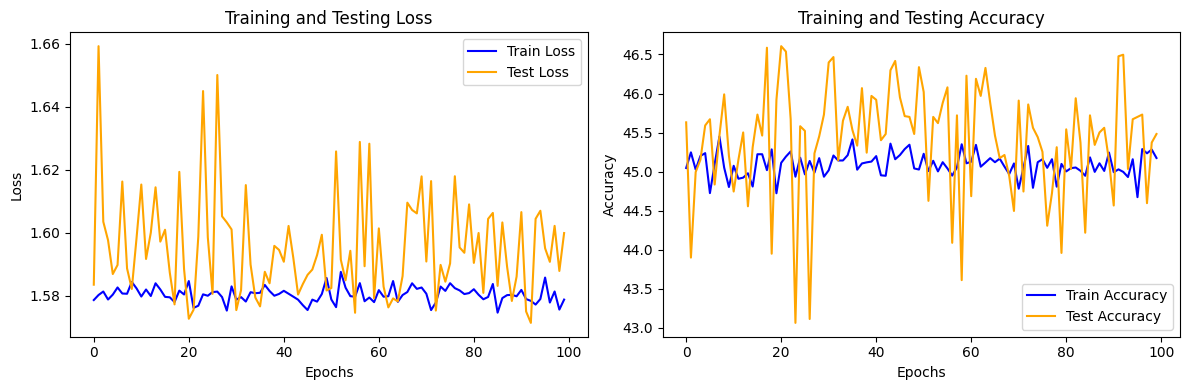

In [ ]:
def plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(test_accuracy, label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)


#VGG-16 MODEL

In [ ]:
from torchvision.models import vgg16

model = vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.8MB/s]


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
  model.to(device)
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
  model.to(device)
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

model.to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train(data_loader = train_loader,
        model = model,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device,
        train_losses = train_losses,
        train_accuracy = train_accuracy
        )
  test(data_loader = test_loader,
       model = model,
       loss_fn = loss_fn,
       accuracy_fn = accuracy_fn,
       device = device,
       test_losses = test_losses,
       test_accuracy = test_accuracy
       )

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.56147 | Train accuracy: 47.31%


  1%|          | 1/100 [00:23<39:07, 23.71s/it]

Test loss: 1.30120 | Test accuracy: 54.17%

Epoch: 1
-------
Train loss: 1.54383 | Train accuracy: 48.98%


  2%|▏         | 2/100 [00:45<37:01, 22.67s/it]

Test loss: 1.29473 | Test accuracy: 55.21%

Epoch: 2
-------
Train loss: 1.54464 | Train accuracy: 49.24%


  3%|▎         | 3/100 [01:07<36:16, 22.44s/it]

Test loss: 1.27489 | Test accuracy: 55.43%

Epoch: 3
-------
Train loss: 1.54509 | Train accuracy: 49.85%


  4%|▍         | 4/100 [01:30<35:52, 22.42s/it]

Test loss: 1.28328 | Test accuracy: 55.43%

Epoch: 4
-------
Train loss: 1.54732 | Train accuracy: 49.60%


  5%|▌         | 5/100 [01:52<35:34, 22.47s/it]

Test loss: 1.28841 | Test accuracy: 55.09%

Epoch: 5
-------
Train loss: 1.55864 | Train accuracy: 49.39%


  6%|▌         | 6/100 [02:15<35:05, 22.40s/it]

Test loss: 1.29957 | Test accuracy: 55.22%

Epoch: 6
-------
Train loss: 1.55705 | Train accuracy: 49.65%


  7%|▋         | 7/100 [02:37<34:36, 22.33s/it]

Test loss: 1.26981 | Test accuracy: 56.10%

Epoch: 7
-------
Train loss: 1.54360 | Train accuracy: 49.89%


  8%|▊         | 8/100 [02:59<34:04, 22.22s/it]

Test loss: 1.29455 | Test accuracy: 55.01%

Epoch: 8
-------
Train loss: 1.54917 | Train accuracy: 49.75%


  9%|▉         | 9/100 [03:21<33:51, 22.33s/it]

Test loss: 1.29245 | Test accuracy: 55.28%

Epoch: 9
-------
Train loss: 1.54629 | Train accuracy: 49.96%


 10%|█         | 10/100 [03:44<33:34, 22.39s/it]

Test loss: 1.31945 | Test accuracy: 54.68%

Epoch: 10
-------
Train loss: 1.55213 | Train accuracy: 49.66%


 11%|█         | 11/100 [04:06<33:13, 22.39s/it]

Test loss: 1.30092 | Test accuracy: 54.77%

Epoch: 11
-------
Train loss: 1.54844 | Train accuracy: 50.07%


 12%|█▏        | 12/100 [04:29<32:50, 22.39s/it]

Test loss: 1.27954 | Test accuracy: 55.21%

Epoch: 12
-------
Train loss: 1.55702 | Train accuracy: 49.62%


 13%|█▎        | 13/100 [04:50<32:08, 22.16s/it]

Test loss: 1.26289 | Test accuracy: 56.81%

Epoch: 13
-------
Train loss: 1.54923 | Train accuracy: 49.81%


 14%|█▍        | 14/100 [05:12<31:47, 22.19s/it]

Test loss: 1.27063 | Test accuracy: 55.44%

Epoch: 14
-------
Train loss: 1.55236 | Train accuracy: 49.57%


 15%|█▌        | 15/100 [05:35<31:27, 22.20s/it]

Test loss: 1.26668 | Test accuracy: 56.38%

Epoch: 15
-------
Train loss: 1.54971 | Train accuracy: 49.61%


 16%|█▌        | 16/100 [05:57<31:08, 22.24s/it]

Test loss: 1.29389 | Test accuracy: 55.36%

Epoch: 16
-------
Train loss: 1.55927 | Train accuracy: 49.64%


 17%|█▋        | 17/100 [06:19<30:46, 22.25s/it]

Test loss: 1.28206 | Test accuracy: 55.76%

Epoch: 17
-------
Train loss: 1.54722 | Train accuracy: 49.85%


 18%|█▊        | 18/100 [06:41<30:21, 22.21s/it]

Test loss: 1.27752 | Test accuracy: 56.19%

Epoch: 18
-------
Train loss: 1.54531 | Train accuracy: 49.76%


 19%|█▉        | 19/100 [07:03<29:51, 22.12s/it]

Test loss: 1.30354 | Test accuracy: 55.10%

Epoch: 19
-------
Train loss: 1.55417 | Train accuracy: 49.77%


 20%|██        | 20/100 [07:26<29:32, 22.16s/it]

Test loss: 1.27546 | Test accuracy: 55.76%

Epoch: 20
-------
Train loss: 1.55308 | Train accuracy: 49.81%


 21%|██        | 21/100 [07:48<29:10, 22.16s/it]

Test loss: 1.29145 | Test accuracy: 55.34%

Epoch: 21
-------
Train loss: 1.55899 | Train accuracy: 49.68%


 22%|██▏       | 22/100 [08:10<28:53, 22.22s/it]

Test loss: 1.27522 | Test accuracy: 56.14%

Epoch: 22
-------
Train loss: 1.55055 | Train accuracy: 49.64%


 23%|██▎       | 23/100 [08:33<28:35, 22.28s/it]

Test loss: 1.27957 | Test accuracy: 55.96%

Epoch: 23
-------
Train loss: 1.54439 | Train accuracy: 49.97%


 24%|██▍       | 24/100 [08:54<28:03, 22.15s/it]

Test loss: 1.27013 | Test accuracy: 56.68%

Epoch: 24
-------
Train loss: 1.55559 | Train accuracy: 49.77%


 25%|██▌       | 25/100 [09:17<27:41, 22.15s/it]

Test loss: 1.28969 | Test accuracy: 55.67%

Epoch: 25
-------
Train loss: 1.55160 | Train accuracy: 50.10%


 26%|██▌       | 26/100 [09:39<27:21, 22.18s/it]

Test loss: 1.28068 | Test accuracy: 55.77%

Epoch: 26
-------
Train loss: 1.55999 | Train accuracy: 49.61%


 27%|██▋       | 27/100 [10:01<27:00, 22.20s/it]

Test loss: 1.27615 | Test accuracy: 56.16%

Epoch: 27
-------
Train loss: 1.55592 | Train accuracy: 49.64%


 28%|██▊       | 28/100 [10:23<26:40, 22.23s/it]

Test loss: 1.30728 | Test accuracy: 55.54%

Epoch: 28
-------
Train loss: 1.55265 | Train accuracy: 49.97%


 29%|██▉       | 29/100 [10:45<26:13, 22.16s/it]

Test loss: 1.30628 | Test accuracy: 55.60%

Epoch: 29
-------
Train loss: 1.55634 | Train accuracy: 49.49%


 30%|███       | 30/100 [11:07<25:43, 22.05s/it]

Test loss: 1.27713 | Test accuracy: 55.67%

Epoch: 30
-------
Train loss: 1.55447 | Train accuracy: 50.00%


 31%|███       | 31/100 [11:29<25:25, 22.10s/it]

Test loss: 1.26982 | Test accuracy: 55.83%

Epoch: 31
-------
Train loss: 1.55364 | Train accuracy: 50.12%


 32%|███▏      | 32/100 [11:52<25:08, 22.18s/it]

Test loss: 1.29036 | Test accuracy: 55.59%

Epoch: 32
-------
Train loss: 1.56138 | Train accuracy: 49.69%


 33%|███▎      | 33/100 [12:14<24:47, 22.21s/it]

Test loss: 1.27929 | Test accuracy: 55.66%

Epoch: 33
-------
Train loss: 1.55491 | Train accuracy: 49.99%


 34%|███▍      | 34/100 [12:36<24:25, 22.20s/it]

Test loss: 1.29522 | Test accuracy: 55.56%

Epoch: 34
-------
Train loss: 1.55298 | Train accuracy: 49.69%


 35%|███▌      | 35/100 [12:58<23:56, 22.10s/it]

Test loss: 1.30758 | Test accuracy: 55.11%

Epoch: 35
-------
Train loss: 1.55158 | Train accuracy: 49.76%


 36%|███▌      | 36/100 [13:20<23:32, 22.07s/it]

Test loss: 1.30592 | Test accuracy: 54.58%

Epoch: 36
-------
Train loss: 1.54901 | Train accuracy: 49.85%


 37%|███▋      | 37/100 [13:42<23:10, 22.06s/it]

Test loss: 1.28534 | Test accuracy: 54.98%

Epoch: 37
-------
Train loss: 1.55311 | Train accuracy: 49.84%


 38%|███▊      | 38/100 [14:04<22:51, 22.12s/it]

Test loss: 1.28188 | Test accuracy: 55.89%

Epoch: 38
-------
Train loss: 1.55070 | Train accuracy: 50.26%


 39%|███▉      | 39/100 [14:27<22:32, 22.18s/it]

Test loss: 1.30309 | Test accuracy: 55.62%

Epoch: 39
-------
Train loss: 1.55693 | Train accuracy: 49.84%


 40%|████      | 40/100 [14:49<22:12, 22.20s/it]

Test loss: 1.25740 | Test accuracy: 56.54%

Epoch: 40
-------
Train loss: 1.55963 | Train accuracy: 49.82%


 41%|████      | 41/100 [15:11<21:42, 22.08s/it]

Test loss: 1.29493 | Test accuracy: 55.30%

Epoch: 41
-------
Train loss: 1.54332 | Train accuracy: 49.92%


 42%|████▏     | 42/100 [15:33<21:20, 22.08s/it]

Test loss: 1.30695 | Test accuracy: 55.14%

Epoch: 42
-------
Train loss: 1.55343 | Train accuracy: 49.80%


 43%|████▎     | 43/100 [15:55<21:03, 22.16s/it]

Test loss: 1.27807 | Test accuracy: 56.14%

Epoch: 43
-------
Train loss: 1.55769 | Train accuracy: 49.57%


 44%|████▍     | 44/100 [16:17<20:43, 22.21s/it]

Test loss: 1.29652 | Test accuracy: 55.12%

Epoch: 44
-------
Train loss: 1.55485 | Train accuracy: 50.00%


 45%|████▌     | 45/100 [16:39<20:18, 22.16s/it]

Test loss: 1.29894 | Test accuracy: 55.21%

Epoch: 45
-------
Train loss: 1.55446 | Train accuracy: 49.85%


 46%|████▌     | 46/100 [17:01<19:52, 22.09s/it]

Test loss: 1.30043 | Test accuracy: 54.76%

Epoch: 46
-------
Train loss: 1.55942 | Train accuracy: 49.62%


 47%|████▋     | 47/100 [17:23<19:28, 22.04s/it]

Test loss: 1.30953 | Test accuracy: 54.82%

Epoch: 47
-------
Train loss: 1.56010 | Train accuracy: 49.81%


 48%|████▊     | 48/100 [17:45<19:07, 22.07s/it]

Test loss: 1.31218 | Test accuracy: 54.91%

Epoch: 48
-------
Train loss: 1.54738 | Train accuracy: 49.90%


 49%|████▉     | 49/100 [18:08<18:48, 22.13s/it]

Test loss: 1.29529 | Test accuracy: 55.50%

Epoch: 49
-------
Train loss: 1.55338 | Train accuracy: 49.90%


 50%|█████     | 50/100 [18:30<18:29, 22.19s/it]

Test loss: 1.29362 | Test accuracy: 55.67%

Epoch: 50
-------
Train loss: 1.56008 | Train accuracy: 49.48%


 51%|█████     | 51/100 [18:52<18:09, 22.23s/it]

Test loss: 1.26330 | Test accuracy: 56.53%

Epoch: 51
-------
Train loss: 1.55479 | Train accuracy: 49.91%


 52%|█████▏    | 52/100 [19:14<17:45, 22.20s/it]

Test loss: 1.26452 | Test accuracy: 56.33%

Epoch: 52
-------
Train loss: 1.55787 | Train accuracy: 49.82%


 53%|█████▎    | 53/100 [19:36<17:13, 21.99s/it]

Test loss: 1.28645 | Test accuracy: 55.98%

Epoch: 53
-------
Train loss: 1.55569 | Train accuracy: 50.00%


 54%|█████▍    | 54/100 [19:58<16:55, 22.07s/it]

Test loss: 1.27274 | Test accuracy: 55.97%

Epoch: 54
-------
Train loss: 1.55080 | Train accuracy: 49.81%


 55%|█████▌    | 55/100 [20:21<16:36, 22.14s/it]

Test loss: 1.27055 | Test accuracy: 56.42%

Epoch: 55
-------
Train loss: 1.54909 | Train accuracy: 50.16%


 56%|█████▌    | 56/100 [20:43<16:15, 22.17s/it]

Test loss: 1.27367 | Test accuracy: 55.81%

Epoch: 56
-------
Train loss: 1.55779 | Train accuracy: 49.77%


 57%|█████▋    | 57/100 [21:05<15:55, 22.21s/it]

Test loss: 1.30175 | Test accuracy: 54.81%

Epoch: 57
-------
Train loss: 1.55040 | Train accuracy: 50.03%


 58%|█████▊    | 58/100 [21:27<15:29, 22.12s/it]

Test loss: 1.28359 | Test accuracy: 55.47%

Epoch: 58
-------
Train loss: 1.55928 | Train accuracy: 49.79%


 59%|█████▉    | 59/100 [21:49<15:05, 22.08s/it]

Test loss: 1.28909 | Test accuracy: 55.40%

Epoch: 59
-------
Train loss: 1.54617 | Train accuracy: 50.20%


 60%|██████    | 60/100 [22:11<14:44, 22.12s/it]

Test loss: 1.29084 | Test accuracy: 54.89%

Epoch: 60
-------
Train loss: 1.55643 | Train accuracy: 49.91%


 61%|██████    | 61/100 [22:33<14:22, 22.11s/it]

Test loss: 1.27708 | Test accuracy: 55.19%

Epoch: 61
-------
Train loss: 1.55917 | Train accuracy: 49.71%


 62%|██████▏   | 62/100 [22:56<14:02, 22.17s/it]

Test loss: 1.29385 | Test accuracy: 55.27%

Epoch: 62
-------
Train loss: 1.54877 | Train accuracy: 49.85%


 63%|██████▎   | 63/100 [23:18<13:40, 22.18s/it]

Test loss: 1.29518 | Test accuracy: 55.32%

Epoch: 63
-------
Train loss: 1.55612 | Train accuracy: 49.69%


 64%|██████▍   | 64/100 [23:40<13:13, 22.04s/it]

Test loss: 1.29670 | Test accuracy: 55.93%

Epoch: 64
-------
Train loss: 1.55225 | Train accuracy: 50.14%


 65%|██████▌   | 65/100 [24:02<12:52, 22.08s/it]

Test loss: 1.28220 | Test accuracy: 55.45%

Epoch: 65
-------
Train loss: 1.55145 | Train accuracy: 49.89%


 66%|██████▌   | 66/100 [24:24<12:32, 22.13s/it]

Test loss: 1.28359 | Test accuracy: 56.35%

Epoch: 66
-------
Train loss: 1.55103 | Train accuracy: 50.11%


 67%|██████▋   | 67/100 [24:46<12:12, 22.19s/it]

Test loss: 1.29685 | Test accuracy: 55.79%

Epoch: 67
-------
Train loss: 1.56324 | Train accuracy: 49.78%


 68%|██████▊   | 68/100 [25:08<11:50, 22.20s/it]

Test loss: 1.27758 | Test accuracy: 56.12%

Epoch: 68
-------
Train loss: 1.55085 | Train accuracy: 49.88%


 69%|██████▉   | 69/100 [25:30<11:23, 22.05s/it]

Test loss: 1.25848 | Test accuracy: 56.51%

Epoch: 69
-------
Train loss: 1.54599 | Train accuracy: 49.93%


 70%|███████   | 70/100 [25:52<10:59, 22.00s/it]

Test loss: 1.29194 | Test accuracy: 55.51%

Epoch: 70
-------
Train loss: 1.55855 | Train accuracy: 49.52%


 71%|███████   | 71/100 [26:14<10:40, 22.09s/it]

Test loss: 1.32060 | Test accuracy: 54.57%

Epoch: 71
-------
Train loss: 1.55281 | Train accuracy: 49.71%


 72%|███████▏  | 72/100 [26:37<10:19, 22.11s/it]

Test loss: 1.29210 | Test accuracy: 55.68%

Epoch: 72
-------
Train loss: 1.56032 | Train accuracy: 49.62%


 73%|███████▎  | 73/100 [26:59<09:58, 22.16s/it]

Test loss: 1.26573 | Test accuracy: 56.32%

Epoch: 73
-------
Train loss: 1.55390 | Train accuracy: 49.94%


 74%|███████▍  | 74/100 [27:21<09:36, 22.19s/it]

Test loss: 1.30275 | Test accuracy: 54.10%

Epoch: 74
-------
Train loss: 1.56394 | Train accuracy: 49.60%


 75%|███████▌  | 75/100 [27:43<09:11, 22.06s/it]

Test loss: 1.26770 | Test accuracy: 56.75%

Epoch: 75
-------
Train loss: 1.55695 | Train accuracy: 49.82%


 76%|███████▌  | 76/100 [28:05<08:48, 22.00s/it]

Test loss: 1.29483 | Test accuracy: 55.03%

Epoch: 76
-------
Train loss: 1.56154 | Train accuracy: 49.54%


 77%|███████▋  | 77/100 [28:27<08:27, 22.05s/it]

Test loss: 1.28035 | Test accuracy: 55.65%

Epoch: 77
-------
Train loss: 1.55027 | Train accuracy: 50.07%


 78%|███████▊  | 78/100 [28:49<08:06, 22.12s/it]

Test loss: 1.28113 | Test accuracy: 56.01%

Epoch: 78
-------
Train loss: 1.54828 | Train accuracy: 49.93%


 79%|███████▉  | 79/100 [29:11<07:44, 22.12s/it]

Test loss: 1.27089 | Test accuracy: 55.76%

Epoch: 79
-------
Train loss: 1.55516 | Train accuracy: 49.86%


 80%|████████  | 80/100 [29:33<07:22, 22.11s/it]

Test loss: 1.28700 | Test accuracy: 55.46%

Epoch: 80
-------
Train loss: 1.55116 | Train accuracy: 49.98%


 81%|████████  | 81/100 [29:55<06:58, 22.01s/it]

Test loss: 1.28073 | Test accuracy: 55.65%

Epoch: 81
-------
Train loss: 1.55455 | Train accuracy: 49.77%


 82%|████████▏ | 82/100 [30:17<06:37, 22.06s/it]

Test loss: 1.29847 | Test accuracy: 55.87%

Epoch: 82
-------
Train loss: 1.55056 | Train accuracy: 50.17%


 83%|████████▎ | 83/100 [30:40<06:16, 22.13s/it]

Test loss: 1.30423 | Test accuracy: 55.14%

Epoch: 83
-------
Train loss: 1.55674 | Train accuracy: 49.76%


 84%|████████▍ | 84/100 [31:02<05:53, 22.11s/it]

Test loss: 1.31199 | Test accuracy: 55.32%

Epoch: 84
-------
Train loss: 1.55625 | Train accuracy: 49.69%


 85%|████████▌ | 85/100 [31:24<05:31, 22.11s/it]

Test loss: 1.26076 | Test accuracy: 56.36%

Epoch: 85
-------
Train loss: 1.55395 | Train accuracy: 49.76%


 86%|████████▌ | 86/100 [31:46<05:08, 22.05s/it]

Test loss: 1.26881 | Test accuracy: 56.10%

Epoch: 86
-------
Train loss: 1.55873 | Train accuracy: 49.95%


 87%|████████▋ | 87/100 [32:08<04:46, 22.00s/it]

Test loss: 1.28120 | Test accuracy: 55.73%

Epoch: 87
-------
Train loss: 1.55357 | Train accuracy: 49.90%


 88%|████████▊ | 88/100 [32:30<04:24, 22.06s/it]

Test loss: 1.29059 | Test accuracy: 55.72%

Epoch: 88
-------
Train loss: 1.55745 | Train accuracy: 49.65%


 89%|████████▉ | 89/100 [32:52<04:03, 22.14s/it]

Test loss: 1.29795 | Test accuracy: 55.87%

Epoch: 89
-------
Train loss: 1.55471 | Train accuracy: 49.80%


 90%|█████████ | 90/100 [33:14<03:41, 22.19s/it]

Test loss: 1.28645 | Test accuracy: 55.44%

Epoch: 90
-------
Train loss: 1.55632 | Train accuracy: 49.65%


 91%|█████████ | 91/100 [33:37<03:19, 22.20s/it]

Test loss: 1.28683 | Test accuracy: 55.44%

Epoch: 91
-------
Train loss: 1.55468 | Train accuracy: 49.92%


 92%|█████████▏| 92/100 [33:58<02:55, 21.97s/it]

Test loss: 1.31552 | Test accuracy: 53.83%

Epoch: 92
-------
Train loss: 1.55868 | Train accuracy: 49.86%


 93%|█████████▎| 93/100 [34:20<02:33, 21.97s/it]

Test loss: 1.29870 | Test accuracy: 55.36%

Epoch: 93
-------
Train loss: 1.54565 | Train accuracy: 49.76%


 94%|█████████▍| 94/100 [34:42<02:12, 22.05s/it]

Test loss: 1.26622 | Test accuracy: 56.33%

Epoch: 94
-------
Train loss: 1.55290 | Train accuracy: 49.81%


 95%|█████████▌| 95/100 [35:04<01:50, 22.09s/it]

Test loss: 1.29766 | Test accuracy: 55.33%

Epoch: 95
-------
Train loss: 1.55494 | Train accuracy: 49.68%


 96%|█████████▌| 96/100 [35:27<01:28, 22.13s/it]

Test loss: 1.28922 | Test accuracy: 54.99%

Epoch: 96
-------
Train loss: 1.54880 | Train accuracy: 49.99%


 97%|█████████▋| 97/100 [35:49<01:06, 22.15s/it]

Test loss: 1.29920 | Test accuracy: 55.12%

Epoch: 97
-------
Train loss: 1.55592 | Train accuracy: 49.71%


 98%|█████████▊| 98/100 [36:11<00:44, 22.05s/it]

Test loss: 1.28889 | Test accuracy: 55.59%

Epoch: 98
-------
Train loss: 1.55868 | Train accuracy: 50.00%


 99%|█████████▉| 99/100 [36:32<00:21, 21.98s/it]

Test loss: 1.26532 | Test accuracy: 56.70%

Epoch: 99
-------
Train loss: 1.55433 | Train accuracy: 50.15%


100%|██████████| 100/100 [36:55<00:00, 22.15s/it]

Test loss: 1.31652 | Test accuracy: 54.88%



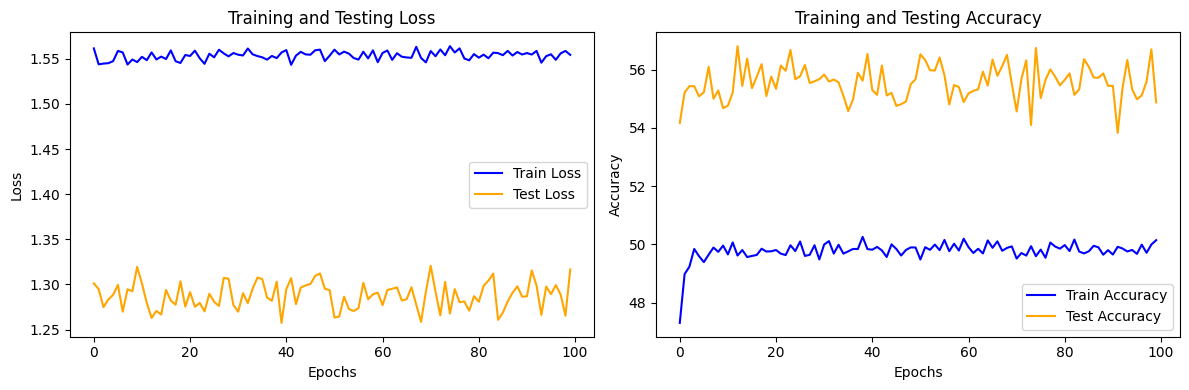

In [ ]:
def plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(test_accuracy, label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)
